# TMY to Power Tutorial

This tutorial will walk through the process of going from TMY data to AC power using the SAPM.

Table of contents:
1. [Setup](#Setup)
2. [Load TMY data](#Load-TMY-data)
2. [Calculate modeling intermediates](#Calculate-modeling-intermediates)
2. [DC power using SAPM](#DC-power-using-SAPM)
2. [AC power using SAPM](#AC-power-using-SAPM)

This tutorial requires pvlib >= 0.6.0.

Authors:
* Will Holmgren (@wholmgren), University of Arizona, July 2015, March 2016, August 2018.
* Rob Andrews (@Calama-Consulting), Heliolytics, June 2014

## Setup

These are just your standard interactive scientific python imports that you'll get very used to using.

In [1]:
# built-in python modules
import os
import inspect

# scientific python add-ons
import numpy as np
import pandas as pd

# plotting stuff
# first line makes the plots appear in the notebook
%matplotlib inline 
import matplotlib.pyplot as plt
import matplotlib as mpl

# finally, we import the pvlib library
import pvlib

## Load TMY data

pvlib comes with a couple of TMY files, and we'll use one of them for simplicity. You could also load a file from disk, or specify a url. See this NREL website for a list of TMY files:

http://rredc.nrel.gov/solar/old_data/nsrdb/1991-2005/tmy3/by_state_and_city.html

In [2]:
# Find the absolute file path to your pvlib installation
pvlib_abspath = os.path.dirname(os.path.abspath(inspect.getfile(pvlib)))

# absolute path to a data file
##datapath = os.path.join(pvlib_abspath, 'data', '703165TY.csv')  # Sand Point, Alaska
# datapath = os.path.join(pvlib_abspath, 'data', '723140TY.csv')  #Charlotte, NC it is found on web or local disk

datapath ='https://rredc.nrel.gov/solar/old_data/nsrdb/1991-2005/data/tmy3/722740TYA.CSV'

# read tmy data with year values coerced to a single year
tmy_data, meta = pvlib.tmy.readtmy3(datapath, coerce_year=2015)
tmy_data.index.name = 'Time'

# TMY data seems to be given as hourly data with time stamp at the end
# shift the index 30 Minutes back for calculation of sun positions
tmy_data = tmy_data.shift(freq='-30Min')['2015']
# tmy_data = tmy_data.shift(freq='-30Min')['2009']
# tmy_data = tmy_data.shift(freq='-30Min')['2010']

C:\Users\Mhdella\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: pvlibDeprecationWarning: The readtmy3 function was deprecated in pvlib 0.6.1 and will be removed in 0.7. Use iotools.read_tmy3 instead.
  # This is added back by InteractiveShellApp.init_path()


In [3]:
# tmy_data.head()
tmy_data.describe()

,ETR,ETRN,GHI,GHISource,GHIUncertainty,DNI,DNISource,DNIUncertainty,DHI,DHISource,...,PwatUncertainty,AOD,AODUncertainty,Alb,AlbUncertainty,Lprecipdepth,Lprecipquantity,LprecipUncertainty,PresWth,PresWthUncertainty
count,8759.000000,8759.000000,8759.000000,8759.000000,8759.000000,8759.000000,8759.000000,8759.000000,8759.000000,8759.000000,...,8759.0,8759.0,8759.0,8759.0,8759.000000,8759.000000,8759.0,8759.0,8759.000000,8759.0
mean,360.314077,689.067702,235.395479,1.336911,5.397648,290.766526,1.336911,6.097728,59.699281,1.336911,...,8.0,0.0,8.0,0.0,2.695285,0.260760,1.0,9.0,2.669825,8.0
std,441.906371,660.466435,315.834946,0.472681,5.190106,368.193698,0.472681,6.302476,86.161927,0.472681,...,0.0,0.0,0.0,0.0,3.781448,4.277463,0.0,0.0,13.272863,0.0
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,...,8.0,0.0,8.0,0.0,0.000000,0.000000,1.0,9.0,0.000000,8.0
25%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,...,8.0,0.0,8.0,0.0,0.000000,0.000000,1.0,9.0,0.000000,8.0
50%,39.000000,760.000000,10.000000,1.000000,8.000000,4.000000,1.000000,9.000000,6.000000,1.000000,...,8.0,0.0,8.0,0.0,0.000000,0.000000,1.0,9.0,0.000000,8.0
75%,762.000000,1352.000000,472.500000,2.000000,9.000000,676.000000,2.000000,9.000000,94.000000,2.000000,...,8.0,0.0,8.0,0.0,8.000000,0.000000,1.0,9.0,0.000000,8.0
max,1305.000000,1415.000000,1067.000000,2.000000,18.000000,1039.000000,2.000000,21.000000,498.000000,2.000000,...,8.0,0.0,8.0,0.0,8.000000,312.000000,1.0,9.0,95.000000,8.0


### Charlotte, NC, CSV can be downloaded from NSRDB website 

In [4]:
# latitude, longitude, name, altitude, timezone
# coordinates = [(35.2, -80.8, 'Charlotte', 232, 'Etc/GMT+4'),
# (40, -105.3, 'Boulder', 1624, 'Etc/GMT+6'),
# (42.3, -71.2, 'Boston', 43, 'Etc/GMT+4'),
# (30, -110, 'Tucson', 700, 'Etc/GMT+7')]

# latitude, longitude, altitude, tz, Name = 35.2, -80.8, 232, 'US/Eastern', 'Charlotte'
# latitude, longitude, tz, Name = 40, -105.3, 1624, 'US/Mountain', 'Boulder'
# latitude, longitude, tz, Name = 42.3, -71.2, 43, 'US/Eastern', 'Boston'
# latitude, longitude, tz, Name = 32.2, -110.9, 700, 'US/Arizona', 'Tucson'

# Location = pvlib.location.Location(latitude, longitude, tz, 
#                                      altitude, Name)
# print(Location)

In [5]:
# # url = 'https://rredc.nrel.gov/solar/old_data/nsrdb/1991-2005/tmy3/by_state_and_city.html'
# url ='https://rredc.nrel.gov/solar/old_data/nsrdb/1991-2005/data/tmy3/723140TYA.CSV'
# # Return just the first 2 lines to get metadata:
# info = pd.read_csv(url, nrows=1)
# info
# # # get data
# df = pd.read_csv(url, skiprows=1)
# tmy_data=df
# # tmy_data = tmy_data.shift(freq='-30Min')['2015']
# tmy_data, meta = pvlib.tmy.readtmy3(datapath, coerce_year=2015)
# tmy_data.index.name = 'Time'

The file handling above looks complicated because we're trying to account for the many different ways that people will run this notebook on their systems. You can just put a simple string path into the ``readtmy3`` function if you know where the file is.

Let's look at the imported version of the TMY file.

This is a ``pandas DataFrame`` object. It has a lot of great properties that are beyond the scope of our tutorials.

Plot the GHI data from the TMY file

Text(0,0.5,'Irradiance (W/m**2)')

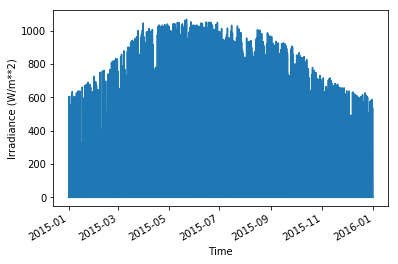

In [6]:
tmy_data['GHI'].plot()
plt.ylabel('Irradiance (W/m**2)')

## Calculate modeling intermediates

Before we can calculate power for all times in the TMY file, we will need to calculate:
* solar position 
* extra terrestrial radiation
* airmass
* angle of incidence
* POA sky and ground diffuse radiation
* cell and module temperatures

First, define some PV system parameters.

In [7]:
surface_tilt = 30
surface_azimuth = 180 # pvlib uses 0=North, 90=East, 180=South, 270=West convention
albedo = 0.2
# print(sand_point)
sand_point = pvlib.location.Location(meta['latitude'], meta['longitude'], tz='US/Alaska', 
                                     altitude=meta['altitude'], name=meta['Name'].replace('"',''))
print(sand_point)

Location: 
  name: TUCSON INTERNATIONAL AP
  latitude: 32.133
  longitude: -110.95
  altitude: 777.0
  tz: US/Alaska


### Solar position

Calculate the solar position for all times in the TMY file. 

The default solar position algorithm is based on Reda and Andreas (2004). Our implementation is pretty fast, but you can make it even faster if you install [``numba``](http://numba.pydata.org/#installing) and use add  ``method='nrel_numba'`` to the function call below.

In [8]:
print(tmy_data.index)

DatetimeIndex(['2015-01-01 00:30:00-07:00', '2015-01-01 01:30:00-07:00',
               '2015-01-01 02:30:00-07:00', '2015-01-01 03:30:00-07:00',
               '2015-01-01 04:30:00-07:00', '2015-01-01 05:30:00-07:00',
               '2015-01-01 06:30:00-07:00', '2015-01-01 07:30:00-07:00',
               '2015-01-01 08:30:00-07:00', '2015-01-01 09:30:00-07:00',
               ...
               '2015-12-31 13:30:00-07:00', '2015-12-31 14:30:00-07:00',
               '2015-12-31 15:30:00-07:00', '2015-12-31 16:30:00-07:00',
               '2015-12-31 17:30:00-07:00', '2015-12-31 18:30:00-07:00',
               '2015-12-31 19:30:00-07:00', '2015-12-31 20:30:00-07:00',
               '2015-12-31 21:30:00-07:00', '2015-12-31 22:30:00-07:00'],
              dtype='datetime64[ns, pytz.FixedOffset(-420)]', name='Time', length=8759, freq=None)


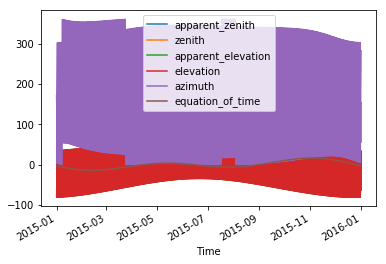

In [9]:
solpos = pvlib.solarposition.get_solarposition(tmy_data.index, sand_point.latitude, sand_point.longitude)

solpos.plot()

The funny looking jump in the azimuth is just due to the coarse time sampling in the TMY file.

### DNI ET

Calculate extra terrestrial radiation. This is needed for many plane of array diffuse irradiance models.

Text(0,0.5,'Extra terrestrial radiation (W/m**2)')

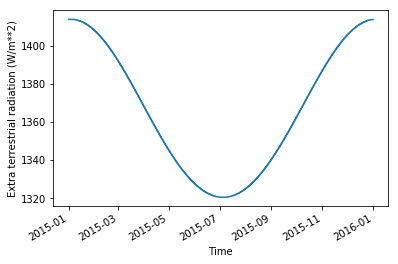

In [10]:
# the extraradiation function returns a simple numpy array
# instead of a nice pandas series. We will change this
# in a future version
dni_extra = pvlib.irradiance.get_extra_radiation(tmy_data.index)
dni_extra = pd.Series(dni_extra, index=tmy_data.index)

dni_extra.plot()
plt.ylabel('Extra terrestrial radiation (W/m**2)')

### Airmass

Calculate airmass. Lots of model options here, see the ``atmosphere`` module tutorial for more details.

Text(0,0.5,'Airmass')

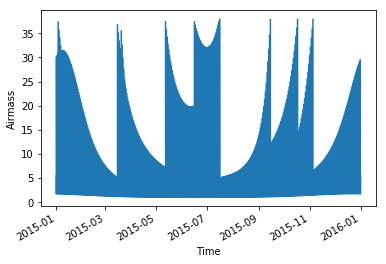

In [11]:
airmass = pvlib.atmosphere.get_relative_airmass(solpos['apparent_zenith'])

airmass.plot()
plt.ylabel('Airmass')

The funny appearance is due to aliasing and setting invalid numbers equal to ``NaN``. Replot just a day or two and you'll see that the numbers are right.

### POA sky diffuse

Use the Hay Davies model to calculate the plane of array diffuse sky radiation. See the ``irradiance`` module tutorial for comparisons of different models.

Text(0,0.5,'Irradiance (W/m**2)')

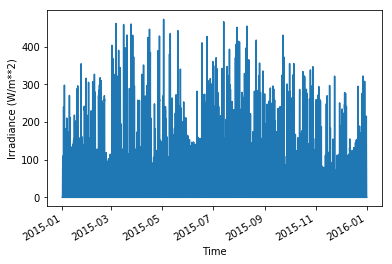

In [12]:
poa_sky_diffuse = pvlib.irradiance.haydavies(surface_tilt, surface_azimuth,
                                             tmy_data['DHI'], tmy_data['DNI'], dni_extra,
                                             solpos['apparent_zenith'], solpos['azimuth'])

poa_sky_diffuse.plot()
plt.ylabel('Irradiance (W/m**2)')

### POA ground diffuse

Calculate ground diffuse. We specified the albedo above. You could have also provided a string to the ``surface_type`` keyword argument.

Text(0,0.5,'Irradiance (W/m**2)')

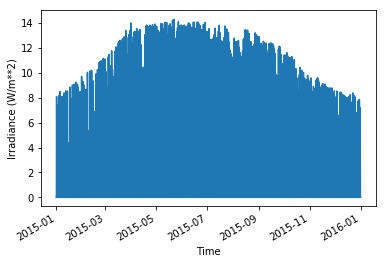

In [13]:
poa_ground_diffuse = pvlib.irradiance.get_ground_diffuse(surface_tilt, tmy_data['GHI'], albedo=albedo)

poa_ground_diffuse.plot()
plt.ylabel('Irradiance (W/m**2)')

### AOI

Calculate AOI

Text(0,0.5,'Angle of incidence (deg)')

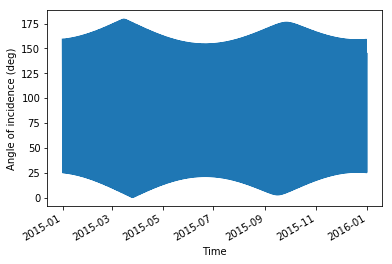

In [14]:
aoi = pvlib.irradiance.aoi(surface_tilt, surface_azimuth, solpos['apparent_zenith'], solpos['azimuth'])

aoi.plot()
plt.ylabel('Angle of incidence (deg)')

Note that AOI has values greater than 90 deg. This is ok.

### POA total

Calculate POA irradiance

Text(0.5,1,'POA Irradiance')

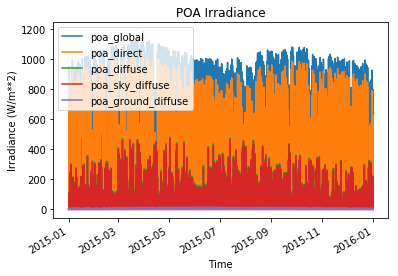

In [15]:
poa_irrad = pvlib.irradiance.poa_components(aoi, tmy_data['DNI'], poa_sky_diffuse, poa_ground_diffuse)

poa_irrad.plot()
plt.ylabel('Irradiance (W/m**2)')
plt.title('POA Irradiance')

### Cell and module temperature

Calculate pv cell and module temperature

Text(0,0.5,'Temperature (C)')

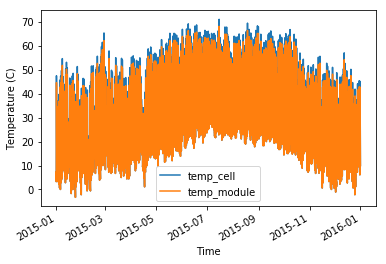

In [16]:
pvtemps = pvlib.pvsystem.sapm_celltemp(poa_irrad['poa_global'], tmy_data['Wspd'], tmy_data['DryBulb'])

pvtemps.plot()
plt.ylabel('Temperature (C)')

## DC power using SAPM

Get module data.

In [17]:
sandia_modules = pvlib.pvsystem.retrieve_sam(name='SandiaMod')

Choose a particular module

In [18]:
sandia_module = sandia_modules.Canadian_Solar_CS5P_220M___2009_
# sandia_module


Calculate the effective irradiance

In [19]:
effective_irradiance = pvlib.pvsystem.sapm_effective_irradiance(poa_irrad.poa_direct, poa_irrad.poa_diffuse, airmass, aoi, sandia_module)

Run the SAPM using the parameters we calculated above.

                           i_sc  i_mp  v_oc  v_mp  p_mp  i_x  i_xx
Time                                                              
2015-01-01 00:30:00-07:00   0.0   0.0   0.0   0.0   0.0  0.0   0.0
2015-01-01 01:30:00-07:00   0.0   0.0   0.0   0.0   0.0  0.0   0.0
2015-01-01 02:30:00-07:00   0.0   0.0   0.0   0.0   0.0  0.0   0.0
2015-01-01 03:30:00-07:00   0.0   0.0   0.0   0.0   0.0  0.0   0.0
2015-01-01 04:30:00-07:00   0.0   0.0   0.0   0.0   0.0  0.0   0.0


Text(0,0.5,'DC Power (W)')

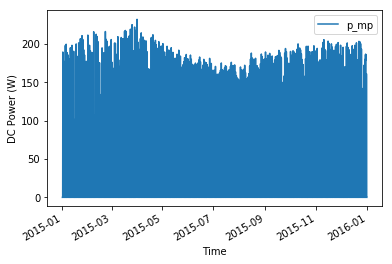

In [20]:
sapm_out = pvlib.pvsystem.sapm(effective_irradiance, pvtemps.temp_cell, sandia_module)
print(sapm_out.head())

sapm_out[['p_mp']].plot()
plt.ylabel('DC Power (W)')

## DC power using single diode

In [21]:
cec_modules = pvlib.pvsystem.retrieve_sam(name='CECMod')
cec_module = cec_modules.Canadian_Solar_CS5P_220M

In [22]:
d = {k: cec_module[k] for k in ['a_ref', 'I_L_ref', 'I_o_ref', 'R_sh_ref', 'R_s']}

In [23]:
photocurrent, saturation_current, resistance_series, resistance_shunt, nNsVth = (
    pvlib.pvsystem.calcparams_desoto(poa_irrad.poa_global,
                                 pvtemps['temp_cell'],
                                 cec_module['alpha_sc'],
                                 EgRef=1.121,
                                 dEgdT=-0.0002677, **d))

In [24]:
single_diode_out = pvlib.pvsystem.singlediode(photocurrent, saturation_current,
                                              resistance_series, resistance_shunt, nNsVth)

Text(0,0.5,'DC Power (W)')

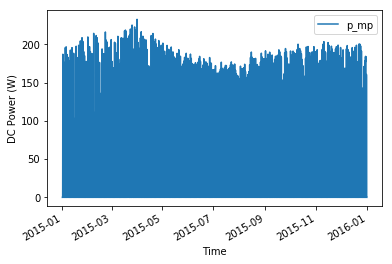

In [25]:
single_diode_out[['p_mp']].plot()
plt.ylabel('DC Power (W)')

## AC power using SAPM

Get the inverter database from the web

In [26]:
sapm_inverters = pvlib.pvsystem.retrieve_sam('sandiainverter')

Choose a particular inverter

In [27]:
sapm_inverter = sapm_inverters['ABB__MICRO_0_25_I_OUTD_US_208_208V__CEC_2014_']
sapm_inverter

Vac          208.000000
Paco         250.000000
Pdco         259.522050
Vdco          40.242603
Pso            1.771614
C0            -0.000025
C1            -0.000090
C2             0.000669
C3            -0.018900
Pnt            0.020000
Vdcmax        65.000000
Idcmax        10.000000
Mppt_low      20.000000
Mppt_high     50.000000
Name: ABB__MICRO_0_25_I_OUTD_US_208_208V__CEC_2014_, dtype: float64

Text(0,0.5,'AC Power (W)')

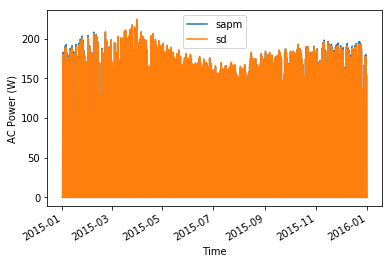

In [28]:
p_acs = pd.DataFrame()
p_acs['sapm'] = pvlib.pvsystem.snlinverter(sapm_out.v_mp, sapm_out.p_mp, sapm_inverter)
p_acs['sd'] = pvlib.pvsystem.snlinverter(single_diode_out.v_mp, single_diode_out.p_mp, sapm_inverter)

p_acs.plot()
plt.ylabel('AC Power (W)')

Text(0,0.5,'SAPM - SD Power (W)')

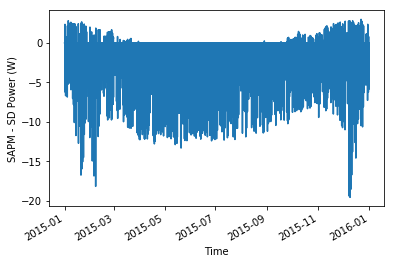

In [29]:
diff = p_acs['sapm'] - p_acs['sd']
diff.plot()
plt.ylabel('SAPM - SD Power (W)')

Plot just a few days.

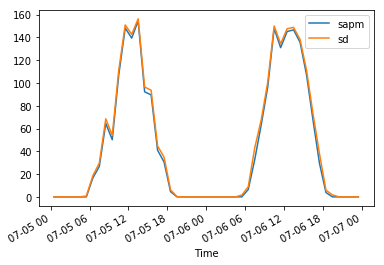

In [30]:
p_acs.loc['2015-07-05':'2015-07-06'].plot()
# p_acs.loc['2009-07-05':'2009-07-06'].plot()
# p_acs.loc['2010-07-05':'2010-07-06'].plot()

Some statistics on the AC power

In [31]:
p_acs.describe()

,sapm,sd
count,8759.000000,8759.000000
mean,48.514382,50.020694
std,66.008600,66.378824
min,-0.020000,-0.020000
25%,-0.020000,-0.020000
50%,-0.020000,0.283338
75%,101.868245,105.788743
max,223.765302,224.323385


In [32]:
p_acs.sum()

sapm    424937.469689
sd      438131.258577
dtype: float64

In [50]:
system_capacity=220
interval=60
NCF=p_acs.sum()/(525600/int(interval) * system_capacity)
NCF

pd.DataFrame({'Energy': [p_acs.sd.sum()], 'NCF':NCF.sd})

,Energy,NCF
0,438131.258577,0.227341


In [34]:
PAC=p_acs.sd
Pac_mnth = p_acs.groupby([lambda p_acs: p_acs.year, lambda p_acs: p_acs.month]).sum()
Pac_mnth
cnt_hrs=p_acs.resample('M').count()
cnt_hrs.sd.mean()
# Pac_mnt

729.9166666666666

In [49]:
NCF_mnth=p_acs.resample('M').mean()
NCF_mnth=NCF_mnth/(60/int(interval) * system_capacity)
NCF_mnth
Pac_mnth
NCF_mnth.sd
NCF_mnth.iloc[:, [0]]
Pac_mnth.iloc[:, [0]]
NCF_mnth.reset_index(drop=True, inplace=True)
Pac_mnth.reset_index(drop=True, inplace=True)

NCF_mnth
Pac_mnth
[Pac_mnth.sd,NCF_mnth.sd]
# df_CF= pd.DataFrame({'Energy': [Pac_mnth.sd], 'NCF': [NCF_mnth.sd]},index=[1, 2, 3, 4,5,6,7,8,9,10,11,12])
df_CF= pd.DataFrame({'Month':np.arange(1,13), 'Energy': Pac_mnth.sd, 'NCF': NCF_mnth.sd})

df_CF
# print(df_CF)


,Month,Energy,NCF
0,1,32631.670026,0.199363
1,2,31464.609770,0.212829
2,3,38343.015282,0.234256
3,4,41304.636547,0.260762
4,5,41329.598665,0.252502
5,6,38467.504424,0.242850
6,7,35637.614947,0.217727
7,8,36685.472791,0.224129
8,9,36643.061688,0.231332
9,10,38215.375146,0.233476


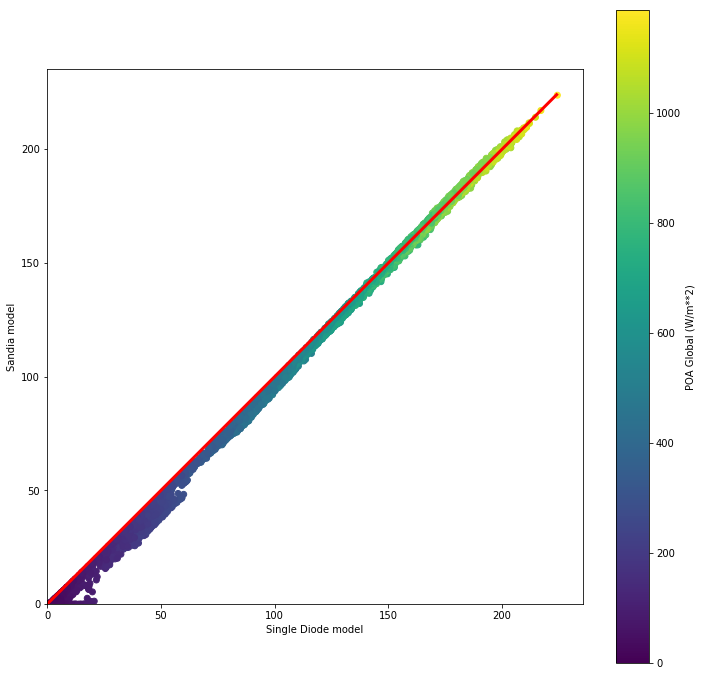

In [36]:
# create data for a y=x line
p_ac_max = p_acs.max().max()
yxline = np.arange(0, p_ac_max)

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, aspect='equal')
sc = ax.scatter(p_acs['sd'], p_acs['sapm'], c=poa_irrad.poa_global, alpha=1)  
ax.plot(yxline, yxline, 'r', linewidth=3)
ax.set_xlim(0, None)
ax.set_ylim(0, None)
ax.set_xlabel('Single Diode model')
ax.set_ylabel('Sandia model')
fig.colorbar(sc, label='POA Global (W/m**2)')

We can change the value of color value ``c`` to see the sensitivity of model accuracy to measured meterological conditions. It can be useful to define a simple plotting function for this kind of exploratory analysis.

In [37]:
def sapm_sd_scatter(c_data, label=None, **kwargs):
    """Display a scatter plot of SAPM p_ac vs. single diode p_ac.
    
    You need to re-execute this cell if you re-run the p_ac calculation.
    
    Parameters
    ----------
    c_data : array-like
        Determines the color of each point on the scatter plot.
        Must be same length as p_acs.
        
    kwargs passed to ``scatter``.
    
    Returns
    -------
    tuple of fig, ax objects
    """
    
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111, aspect='equal')
    sc = ax.scatter(p_acs['sd'], p_acs['sapm'], c=c_data, alpha=1, **kwargs)  
    ax.plot(yxline, yxline, 'r', linewidth=3)
    ax.set_xlim(0, None)
    ax.set_ylim(0, None)
    ax.set_xlabel('Single diode model power (W)')
    ax.set_ylabel('Sandia model power (W)')
    fig.colorbar(sc, label='{}'.format(label), shrink=0.75)
    
    return fig, ax

(<Figure size 864x864 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1d09df84748>)

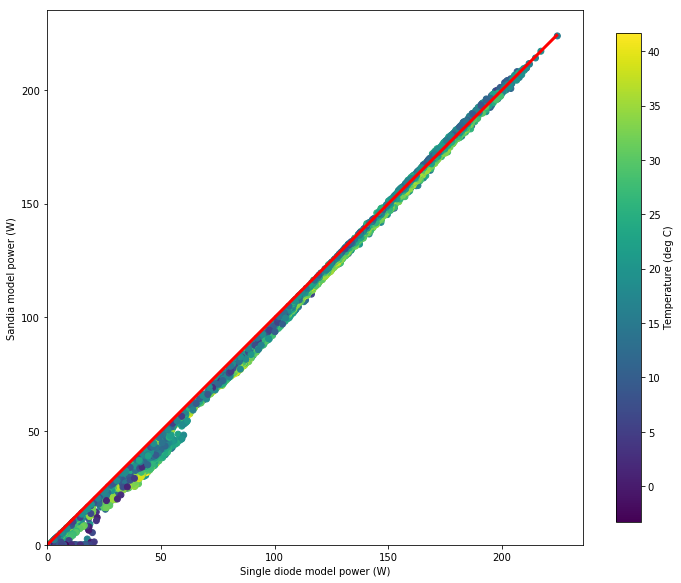

In [38]:
sapm_sd_scatter(tmy_data.DryBulb, label='Temperature (deg C)')

(<Figure size 864x864 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1d09e365ba8>)

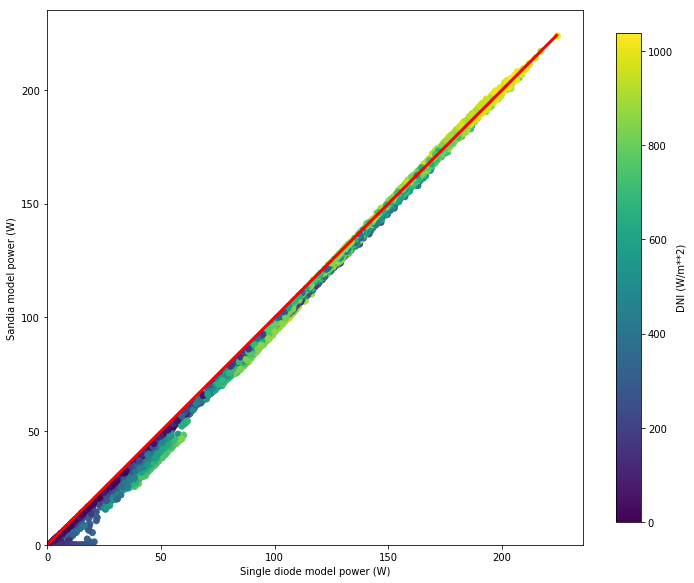

In [39]:
sapm_sd_scatter(tmy_data.DNI, label='DNI (W/m**2)')

(<Figure size 864x864 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1d09e59fe10>)

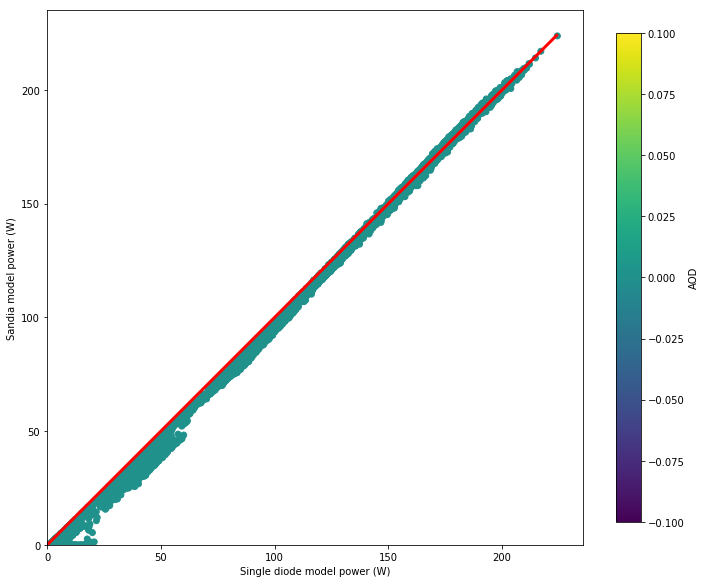

In [40]:
sapm_sd_scatter(tmy_data.AOD, label='AOD')

(<Figure size 864x864 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1d09e58e390>)

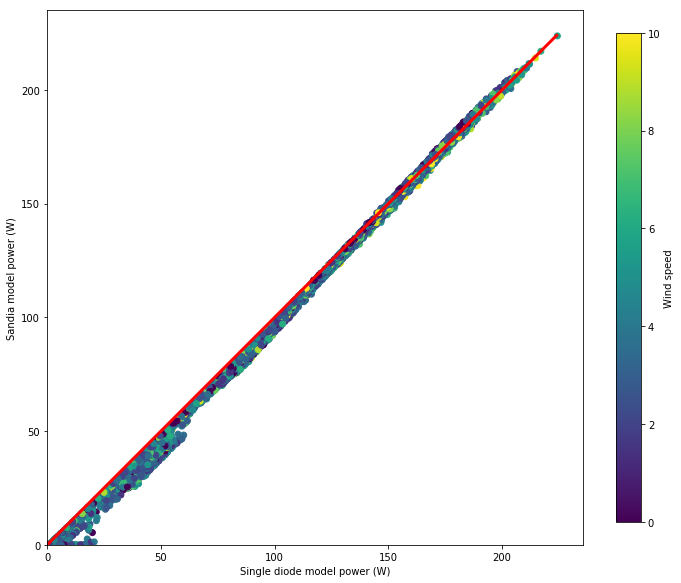

In [41]:
sapm_sd_scatter(tmy_data.Wspd, label='Wind speed', vmax=10)

Notice the use of the ``vmax`` keyword argument in the above example. The ``**kwargs`` pattern allows us to easily pass non-specified arguments to nested functions.

In [42]:
def sapm_other_scatter(c_data, x_data, clabel=None, xlabel=None, aspect_equal=False, **kwargs):
    """Display a scatter plot of SAPM p_ac vs. something else.
    
    You need to re-execute this cell if you re-run the p_ac calculation.
    
    Parameters
    ----------
    c_data : array-like
        Determines the color of each point on the scatter plot.
        Must be same length as p_acs.
    x_data : array-like
        
    kwargs passed to ``scatter``.
    
    Returns
    -------
    tuple of fig, ax objects
    """
    
    fig = plt.figure(figsize=(12,12))
    
    if aspect_equal:
        ax = fig.add_subplot(111, aspect='equal')
    else:
        ax = fig.add_subplot(111)
    sc = ax.scatter(x_data, p_acs['sapm'], c=c_data, alpha=1, cmap=mpl.cm.YlGnBu_r, **kwargs)  
    ax.set_xlim(0, None)
    ax.set_ylim(0, None)
    ax.set_xlabel('{}'.format(xlabel))
    ax.set_ylabel('Sandia model power (W)')
    fig.colorbar(sc, label='{}'.format(clabel), shrink=0.75)
    
    return fig, ax

(<Figure size 864x864 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1d09e8d9358>)

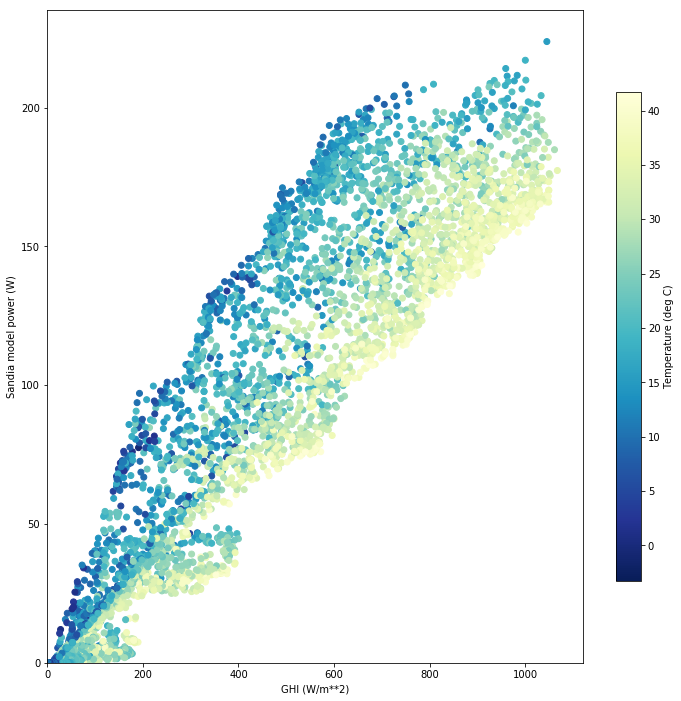

In [43]:
sapm_other_scatter(tmy_data.DryBulb, tmy_data.GHI, clabel='Temperature (deg C)', xlabel='GHI (W/m**2)')

Next, we will assume that the SAPM model is representative of the real world performance so that we can use scipy's optimization routine to derive simulated PVUSA coefficients. You will need to install scipy to run these functions.

Here's one PVUSA reference:

http://www.nrel.gov/docs/fy09osti/45376.pdf


In [44]:
def pvusa(pvusa_data, a, b, c, d):
    """
    Calculates system power according to the PVUSA equation
    
    P = I * (a + b*I + c*W + d*T)
    
    where
    P is the output power,
    I is the plane of array irradiance,
    W is the wind speed, and
    T is the temperature
    
    Parameters
    ----------
    pvusa_data : pd.DataFrame
        Must contain the columns 'I', 'W', and 'T'
    a : float
        I coefficient
    b : float
        I*I coefficient
    c : float
        I*W coefficient
    d : float
        I*T coefficient
    
    Returns
    -------
    power : pd.Series
        Power calculated using the PVUSA model.
    """
    return pvusa_data['I'] * (a + b*pvusa_data['I'] + c*pvusa_data['W'] + d*pvusa_data['T'])

In [45]:
from scipy import optimize

In [46]:
pvusa_data = pd.DataFrame()
pvusa_data['I'] = poa_irrad.poa_global
pvusa_data['W'] = tmy_data.Wspd
pvusa_data['T'] = tmy_data.DryBulb

In [47]:
popt, pcov = optimize.curve_fit(pvusa, pvusa_data.dropna(), p_acs.sapm.values, p0=(.0001,0.0001,.001,.001))
print('optimized coefs:\n{}'.format(popt))
print('covariances:\n{}'.format(pcov))

optimized coefs:
[ 2.16037304e-01 -6.38011166e-06  1.11597252e-03 -1.16079457e-03]
covariances:
[[ 1.12880681e-07 -7.88482617e-11 -2.82588993e-09 -1.25067563e-09]
 [-7.88482617e-11  1.01208258e-13  2.57612760e-13 -2.28186924e-13]
 [-2.82588993e-09  2.57612760e-13  7.66989754e-10 -1.45030994e-11]
 [-1.25067563e-09 -2.28186924e-13 -1.45030994e-11  5.72947358e-11]]


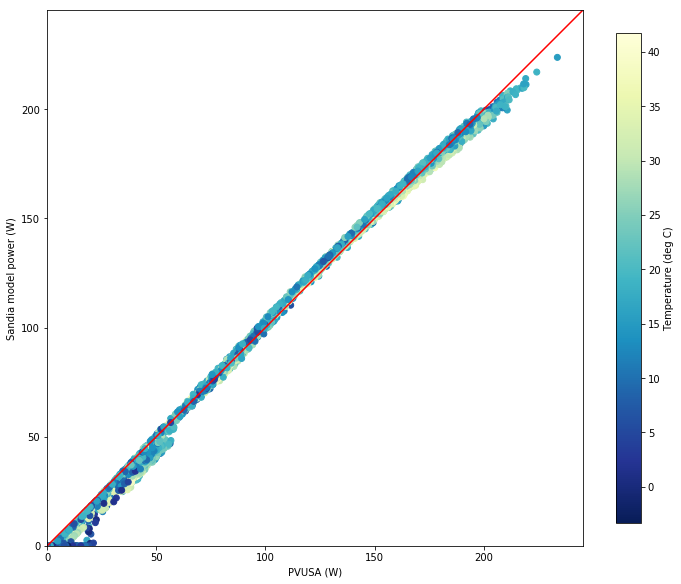

In [48]:
power_pvusa = pvusa(pvusa_data, *popt)

fig, ax = sapm_other_scatter(tmy_data.DryBulb, power_pvusa, clabel='Temperature (deg C)',
                             aspect_equal=True, xlabel='PVUSA (W)')

maxmax = max(ax.get_xlim()[1], ax.get_ylim()[1])
ax.set_ylim(None, maxmax)
ax.set_xlim(None, maxmax)
ax.plot(np.arange(maxmax), np.arange(maxmax), 'r')